## Introduction

The goal of this project is to apply Linear Regression on data scraped from Amazon Best Seller Book   website, to predict the price of book based on the features of that book (book name, author, rating, customer rated, year and genre).



## Import Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Web Scraping Functions

In [2]:
no_pages = 2

def get_data(pageNo):  
    headers = {"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0", "Accept-Encoding":"gzip, deflate", "Accept":"text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8", "DNT":"1","Connection":"close", "Upgrade-Insecure-Requests":"1"}

    r = requests.get('https://www.amazon.in/gp/bestsellers/books/22960344031/ref=zg_bs_nav_b_1_b'+str(pageNo)+'?ie=UTF8&pg='+str(pageNo), headers=headers)#, proxies=proxies)
    content = r.content
    soup = BeautifulSoup(content)
    #print(soup)

    alls = []
    for d in soup.findAll('div', attrs={'class':'a-section a-spacing-none aok-relative'}):
        #print(d)
        name = d.find('span', attrs={'class':'zg-text-center-align'})
        n = name.find_all('img', alt=True)
        #print(n[0]['alt'])
        author = d.find('a', attrs={'class':'a-size-small a-link-child'})
        rating = d.find('span', attrs={'class':'a-icon-alt'})
        users_rated = d.find('a', attrs={'class':'a-size-small a-link-normal'})
        price = d.find('span', attrs={'class':'p13n-sc-price'})

        all1=[]

        if name is not None:
            #print(n[0]['alt'])
            all1.append(n[0]['alt'])
        else:
            all1.append("unknown-product")

        if author is not None:
            #print(author.text)
            all1.append(author.text)
        elif author is None:
            author = d.find('span', attrs={'class':'a-size-small a-color-base'})
            if author is not None:
                all1.append(author.text)
            else:    
                all1.append('0')

        if rating is not None:
            #print(rating.text)
            all1.append(rating.text)
        else:
            all1.append('-1')

        if users_rated is not None:
            #print(price.text)
            all1.append(users_rated.text)
        else:
            all1.append('0')     

        if price is not None:
            #print(price.text)
            all1.append(price.text)
        else:
            all1.append('0')
        alls.append(all1)    
    return alls

In [3]:
results = []
for i in range(1, no_pages+1):
    results.append(get_data(i))
flatten = lambda l: [item for sublist in l for item in sublist]
df = pd.DataFrame(flatten(results),columns=['Book_Name','Author','Rating','Customers_Rated', 'Price'])
df.to_csv('amazon_products.csv', index=False, encoding='utf-8')

In [4]:
df1 = pd.read_csv("amazon_products.csv")

## EDA

In [5]:
df1.shape

(50, 5)

In [6]:
df1.head(100)

,Book_Name,Author,Rating,Customers_Rated,Price
0,Basic Electrical Engineering | 2nd Edition,Abhijit Chakrabarti,-1,0,₹607.00
1,The 8051 Microcontroller and Embedded Systems:...,MAZIDI,4.4 out of 5 stars,371,₹449.00
2,Microbiology,Michael Pelczar,4.4 out of 5 stars,260,₹903.00
3,The Physics of Waves and Oscillations,N Bajaj,4.3 out of 5 stars,153,₹522.00
4,Basic Electrical and Electronics Engineering |...,S.K. Bhattacharya,4.2 out of 5 stars,77,₹519.00
5,AICTE Recommended| Network analysis| By Pearson,M. E. Van Valkenburg/T.S. Rathore,4.3 out of 5 stars,117,₹520.00
6,Signals and Systems | Second Edition | By Pearson,Oppenheim/Willsky/Hamid,4.4 out of 5 stars,226,₹653.00
7,Electronic Principles (SIE) | 7th Edition,Albert Malvino,4.3 out of 5 stars,232,₹499.00
8,A Textbook of Strength of Materials: Mechanics...,R.K. Bansal,4.3 out of 5 stars,457,₹694.00
9,Microelectronic Circuits: Theory And Applicati...,Adel S. Sedra,4.6 out of 5 stars,333,₹755.00


## Check and Clean Data

In [7]:
df1['Rating'] = df1['Rating'].apply(lambda x: x.split()[0]) #split then take first element

In [8]:
df1['Rating'] = pd.to_numeric(df1['Rating']) 

In [9]:
df1["Price"] = df1["Price"].str.replace('₹', '') #  Clean  data
df1["Price"] = df1["Price"].str.replace(',', '')
df1['Price'] = df1['Price'].apply(lambda x: x.split('.')[0])
df1['Price'] = df1['Price'].astype(int)

In [10]:
df1["Customers_Rated"] = df1["Customers_Rated"].str.replace(',', '')

In [11]:
df1['Customers_Rated'] = pd.to_numeric(df1['Customers_Rated'], errors='ignore')

In [12]:
df1.head()

,Book_Name,Author,Rating,Customers_Rated,Price
0,Basic Electrical Engineering | 2nd Edition,Abhijit Chakrabarti,-1.0,0,607
1,The 8051 Microcontroller and Embedded Systems:...,MAZIDI,4.4,371,449
2,Microbiology,Michael Pelczar,4.4,260,903
3,The Physics of Waves and Oscillations,N Bajaj,4.3,153,522
4,Basic Electrical and Electronics Engineering |...,S.K. Bhattacharya,4.2,77,519


In [13]:
df1.dtypes

Book_Name           object
Author              object
Rating             float64
Customers_Rated      int64
Price                int64
dtype: object

In [14]:
df1.replace(str(0), np.nan, inplace=True)
df1.replace(0, np.nan, inplace=True)

In [15]:
df1['Genre']='Non Fiction'
df1['Year']='2021'
df1['Year'] = pd.to_numeric(df1['Year'], errors='ignore')

In [16]:
df1.dtypes

Book_Name           object
Author              object
Rating             float64
Customers_Rated    float64
Price                int64
Genre               object
Year                 int64
dtype: object

In [17]:
df1.isna().sum()

Book_Name          0
Author             0
Rating             0
Customers_Rated    1
Price              0
Genre              0
Year               0
dtype: int64

In [18]:
df1['Customers_Rated'] = df1['Customers_Rated'].fillna(0)
df1['Author'] = df1['Author'].fillna(0)
df1['Rating'] = df1['Rating'].fillna(0)
df1['Price'] = df1['Price'].fillna(0)

In [19]:
df1.isna().sum()

Book_Name          0
Author             0
Rating             0
Customers_Rated    0
Price              0
Genre              0
Year               0
dtype: int64

In [20]:
df2 = pd.read_csv("AmazonBooks - Sheet1.csv") # import csv file

In [21]:
df2

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
595,Live Free Or Die: America (and the World) on t...,Sean Hannity,4.8,20153,15,2020,Non Fiction
596,Burn After Writing,Sharon Jones,4.6,26423,8,2020,Non Fiction
597,Get Out of Your Head: Stopping the Spiral of T...,Jennie Allen,4.7,12879,14,2020,Non Fiction
598,Human Body Activity Book for Kids: Hands-On Fu...,Katie Stokes,4.7,14128,5,2020,Non Fiction


In [22]:
df2.rename(columns={"Name":"Book_Name"}, inplace= True)# 
df2.rename(columns={"User Rating":"Rating"}, inplace= True)
df2.rename(columns={"Reviews":"Customers_Rated"}, inplace= True)

In [23]:
df2

,Book_Name,Author,Rating,Customers_Rated,Price,Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
595,Live Free Or Die: America (and the World) on t...,Sean Hannity,4.8,20153,15,2020,Non Fiction
596,Burn After Writing,Sharon Jones,4.6,26423,8,2020,Non Fiction
597,Get Out of Your Head: Stopping the Spiral of T...,Jennie Allen,4.7,12879,14,2020,Non Fiction
598,Human Body Activity Book for Kids: Hands-On Fu...,Katie Stokes,4.7,14128,5,2020,Non Fiction


In [24]:
df = pd.concat([df1, df2], axis=0) #Combining datasets

In [25]:
df.shape

(650, 7)

## Create Dummy Variables

In [26]:
dummy= pd.get_dummies(df['Genre'])
dummy

,Fiction,Non Fiction
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
595,0,1
596,0,1
597,0,1
598,0,1


In [27]:
df=pd.concat([df ,dummy ] , axis=1)

In [28]:
df.head(100)

,Book_Name,Author,Rating,Customers_Rated,Price,Genre,Year,Fiction,Non Fiction
0,Basic Electrical Engineering | 2nd Edition,Abhijit Chakrabarti,-1.0,0.0,607,Non Fiction,2021,0,1
1,The 8051 Microcontroller and Embedded Systems:...,MAZIDI,4.4,371.0,449,Non Fiction,2021,0,1
2,Microbiology,Michael Pelczar,4.4,260.0,903,Non Fiction,2021,0,1
3,The Physics of Waves and Oscillations,N Bajaj,4.3,153.0,522,Non Fiction,2021,0,1
4,Basic Electrical and Electronics Engineering |...,S.K. Bhattacharya,4.2,77.0,519,Non Fiction,2021,0,1
...,...,...,...,...,...,...,...,...,...
45,Capital in the Twenty First Century,Thomas Piketty,4.5,2884.0,28,Non Fiction,2014,0,1
46,Catching Fire (The Hunger Games),Suzanne Collins,4.7,22614.0,11,Fiction,2010,1,0
47,Catching Fire (The Hunger Games),Suzanne Collins,4.7,22614.0,11,Fiction,2011,1,0
48,Catching Fire (The Hunger Games),Suzanne Collins,4.7,22614.0,11,Fiction,2012,1,0


In [29]:
filter = df[df['Genre'] == 'Fiction']
print(filter)



                                             Book_Name  ... Non Fiction
1                                    11/22/63: A Novel  ...           0
3                               1984 (Signet Classics)  ...           0
5        A Dance with Dragons (A Song of Ice and Fire)  ...           0
6    A Game of Thrones / A Clash of Kings / A Storm...  ...           0
7                       A Gentleman in Moscow: A Novel  ...           0
..                                                 ...  ...         ...
590                              What Should Danny Do?  ...           0
591                   Wacky Waving Inflatable Tube Guy  ...           0
592                                The Silent Patient   ...           0
593               The Big Book of Silly Jokes for Kids  ...           0
594                           Chicka Chicka Boom Boom   ...           0

[263 rows x 9 columns]


In [30]:
df.shape

(650, 9)

In [31]:
print(df.duplicated().sum()) #Check for duplicate values

0


In [32]:
df.isna().sum() #Check null value

Book_Name          0
Author             0
Rating             0
Customers_Rated    0
Price              0
Genre              0
Year               0
Fiction            0
Non Fiction        0
dtype: int64

In [33]:
df.drop_duplicates()

,Book_Name,Author,Rating,Customers_Rated,Price,Genre,Year,Fiction,Non Fiction
0,Basic Electrical Engineering | 2nd Edition,Abhijit Chakrabarti,-1.0,0.0,607,Non Fiction,2021,0,1
1,The 8051 Microcontroller and Embedded Systems:...,MAZIDI,4.4,371.0,449,Non Fiction,2021,0,1
2,Microbiology,Michael Pelczar,4.4,260.0,903,Non Fiction,2021,0,1
3,The Physics of Waves and Oscillations,N Bajaj,4.3,153.0,522,Non Fiction,2021,0,1
4,Basic Electrical and Electronics Engineering |...,S.K. Bhattacharya,4.2,77.0,519,Non Fiction,2021,0,1
...,...,...,...,...,...,...,...,...,...
595,Live Free Or Die: America (and the World) on t...,Sean Hannity,4.8,20153.0,15,Non Fiction,2020,0,1
596,Burn After Writing,Sharon Jones,4.6,26423.0,8,Non Fiction,2020,0,1
597,Get Out of Your Head: Stopping the Spiral of T...,Jennie Allen,4.7,12879.0,14,Non Fiction,2020,0,1
598,Human Body Activity Book for Kids: Hands-On Fu...,Katie Stokes,4.7,14128.0,5,Non Fiction,2020,0,1


In [34]:
df.isna() #Check null value

,Book_Name,Author,Rating,Customers_Rated,Price,Genre,Year,Fiction,Non Fiction
0,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
595,False,False,False,False,False,False,False,False,False
596,False,False,False,False,False,False,False,False,False
597,False,False,False,False,False,False,False,False,False
598,False,False,False,False,False,False,False,False,False


In [35]:
df.reset_index(inplace=True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            650 non-null    int64  
 1   Book_Name        650 non-null    object 
 2   Author           650 non-null    object 
 3   Rating           650 non-null    float64
 4   Customers_Rated  650 non-null    float64
 5   Price            650 non-null    int64  
 6   Genre            650 non-null    object 
 7   Year             650 non-null    int64  
 8   Fiction          650 non-null    uint8  
 9   Non Fiction      650 non-null    uint8  
dtypes: float64(2), int64(3), object(3), uint8(2)
memory usage: 42.0+ KB


In [37]:
# transform dependent variable
df["Price"] = np.sqrt(df["Price"])

## Initial Graphs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


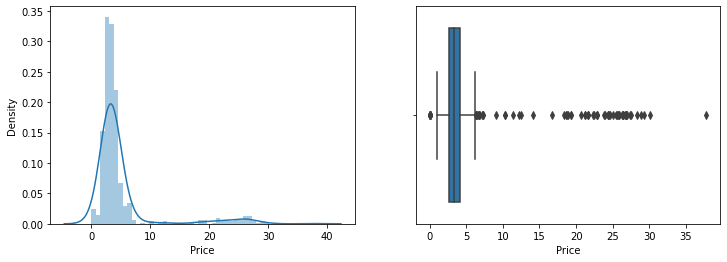

In [38]:

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.distplot(df["Price"])

plt.subplot(1,2,2)
sns.boxplot(df["Price"]);

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


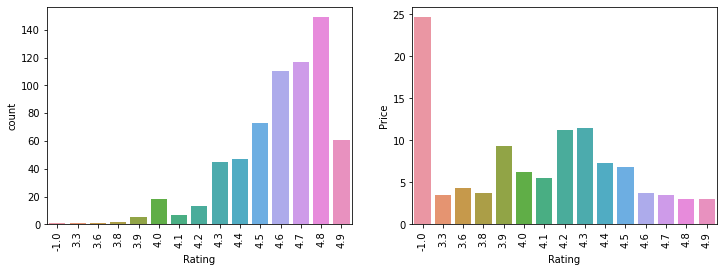

In [39]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.countplot(df["Rating"])
plt.xticks(rotation="vertical")

plt.subplot(1,2,2)
sns.barplot(x=df["Rating"], y=df["Price"], ci=None)
plt.xticks(rotation="vertical");

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


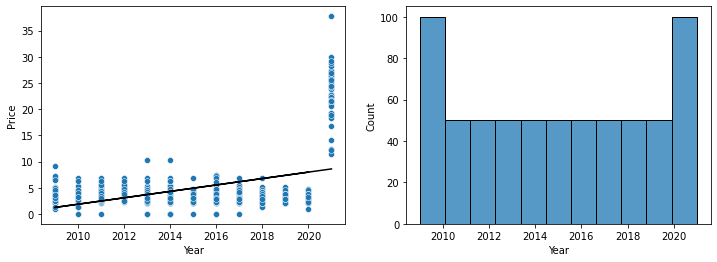

In [40]:
x = df["Year"]
y = df["Price"]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.scatterplot(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="black")

plt.subplot(1,2,2)
sns.histplot(x);   

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


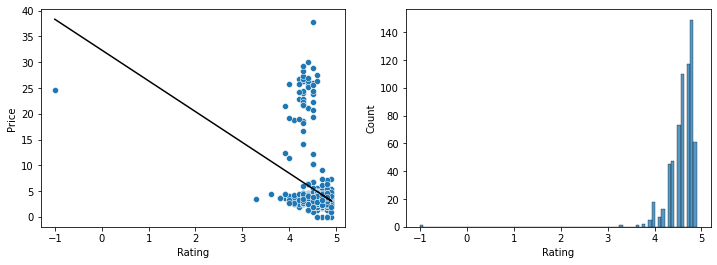

In [41]:
x = df["Rating"] #Customers_Rated
y = df["Price"]

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.scatterplot(x, y)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color="black")

plt.subplot(1,2,2)
sns.histplot(x);

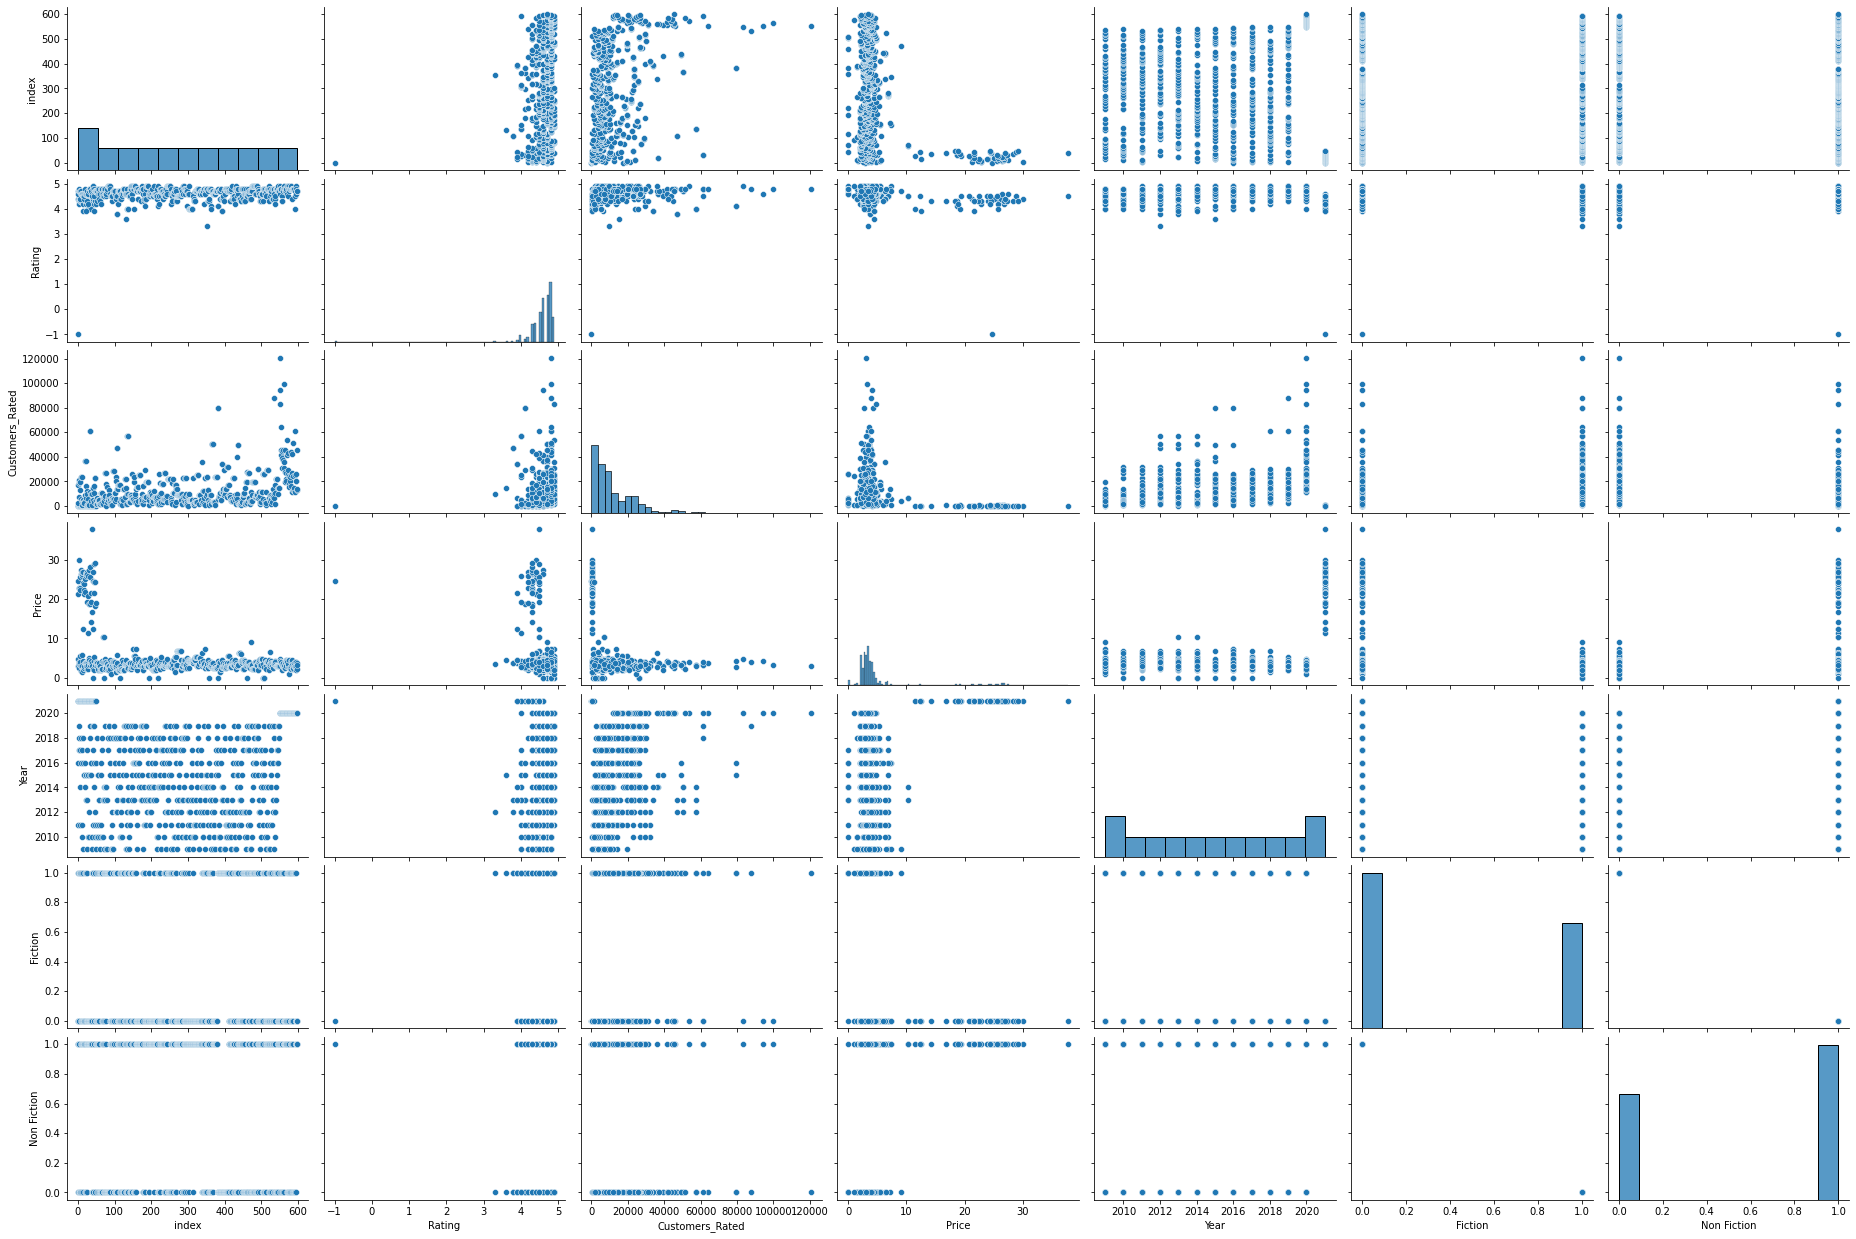

In [42]:
sns.pairplot(df,aspect=1.5);


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


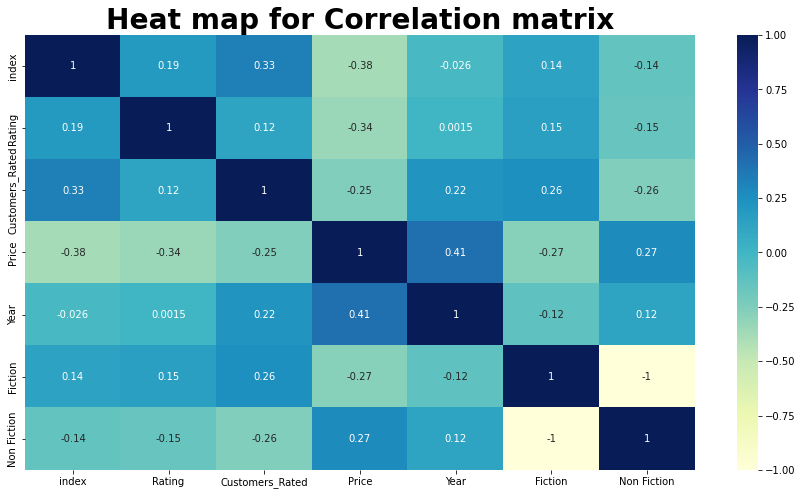

In [43]:
corr=df.corr()
plt.figure(figsize=(15,8))
plt.title("Heat map for Correlation matrix", fontname="Times New Roman", size=28, fontweight="bold")
sns.heatmap(corr,annot=True,cmap="YlGnBu")

In [44]:
df.describe()

,index,Rating,Customers_Rated,Price,Year,Fiction,Non Fiction
count,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000,650.000000
mean,278.346154,4.595538,12886.249231,4.915478,2015.000000,0.404615,0.595385
std,182.013846,0.322158,14544.949100,5.626915,3.744539,0.491195,0.491195
min,0.000000,-1.000000,0.000000,0.000000,2009.000000,0.000000,0.000000
25%,112.250000,4.500000,3493.250000,2.691420,2012.000000,0.000000,0.000000
50%,274.500000,4.700000,8580.000000,3.316625,2015.000000,0.000000,1.000000
75%,436.750000,4.800000,19546.000000,4.123106,2018.000000,1.000000,1.000000
max,599.000000,4.900000,120727.000000,37.749172,2021.000000,1.000000,1.000000


In [45]:
df.corr()

,index,Rating,Customers_Rated,Price,Year,Fiction,Non Fiction
index,1.000000,0.190916,0.332490,-0.376193,-0.025727,0.135910,-0.135910
Rating,0.190916,1.000000,0.121102,-0.341968,0.001533,0.149693,-0.149693
Customers_Rated,0.332490,0.121102,1.000000,-0.252982,0.221181,0.256044,-0.256044
Price,-0.376193,-0.341968,-0.252982,1.000000,0.408113,-0.273448,0.273448
Year,-0.025727,0.001533,0.221181,0.408113,1.000000,-0.119795,0.119795
Fiction,0.135910,0.149693,0.256044,-0.273448,-0.119795,1.000000,-1.000000
Non Fiction,-0.135910,-0.149693,-0.256044,0.273448,0.119795,-1.000000,1.000000


# Linear Regression Models

In [46]:
cols = ['Rating',	'Customers_Rated'	,	'Year' ,'Price' , 'Fiction' ,	'Non Fiction']
new_df = df[cols]

In [47]:
model = sm.OLS(new_df["Price"], sm.add_constant(new_df.drop(columns="Price")))
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     103.1
Date:                Sat, 23 Oct 2021   Prob (F-statistic):           7.66e-68
Time:                        18:27:26   Log-Likelihood:                -1884.1
No. Observations:                 650   AIC:                             3778.
Df Residuals:                     645   BIC:                             3801.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -912.4090     64.797    -14.081      0.000   -1039.647    -785.171
Rating             -5.1037      0.545     -9.359      0.000      -6.175      -4.033
Customers_Rated    -0.0001   1.28e-05     -8.897      0.000      -0.000   -8.88e-05
Year                0.6940      0.048     14.386      0.000       0.599       0.789
Fiction          -456.7716     32.365    -14.113      0.000    -520.325    -393.218
Non Fiction      -455.6374     32.433    -14.049      0.000    -519.324    -391.951
==============================================================================
Omnibus:                      242.627   Durbin-Watson:                   0.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              948.692
Skew:                           1.715   Prob(JB):                    9.86e-207
Kurtosis:                       7.823   Cond. No.                     4.10e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.47e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

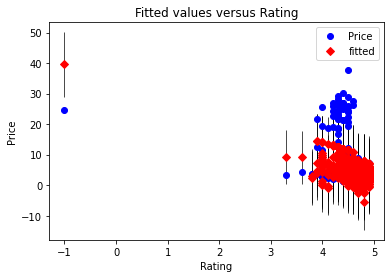

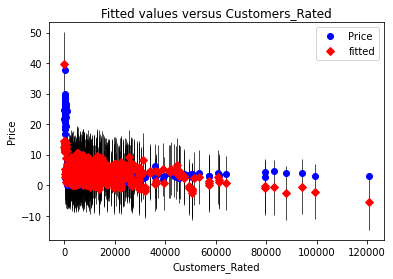

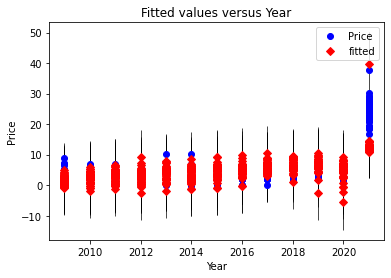

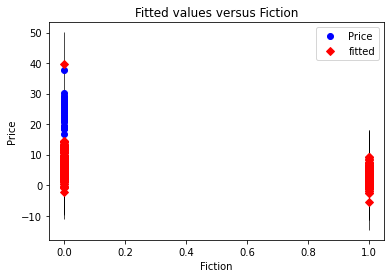

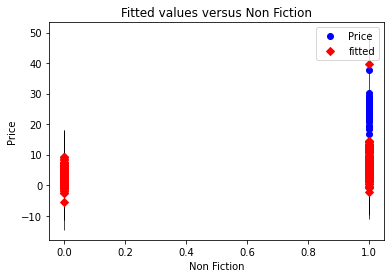

In [48]:
for i in [1,2,3 ,4,5]:
    fig, ax = plt.subplots()
    fig = sm.graphics.plot_fit(fit, i, ax=ax)

In [49]:
print("Mean Squared Error :", mse(new_df["Price"], fit.predict()))
print("Mean Absolute Error :", mae(new_df["Price"], fit.predict()))

Mean Squared Error : 19.285956769265717
Mean Absolute Error : 3.0634668754610646



## Cross-Validation

In [50]:
def report_scores(data, test_size=0.2, random_state=40):
    # define x and y
    x = data.drop(columns="Price")
    y = data["Price"]
    
    # split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    # create the model
    model = LinearRegression()
    fit = model.fit(x_train, y_train)

    # print the results
    print("R² training set :", fit.score(x_train, y_train))
    print("R² test set :", fit.score(x_test, y_test))
    print("")
    print("Mean Squared Error :", mse(y, fit.predict(x)))
    print("Mean Absolute Error :", mae(y, fit.predict(x)))
    print("")
    
    # create a dataframe of the coefficients and the intercept
    results = pd.DataFrame(list(zip(x.columns, fit.coef_)), columns=["Features", "Coefficients"])
    results.loc[-1] = ["Intercept", fit.intercept_]
    results.index += 1
    results = results.sort_index()
    results["Squared"] = results["Coefficients"]**2
    
    # return the data
    return x, y, x_train, x_test, y_train, y_test, fit.predict(x), results

In [51]:
def cv_models(data, test_size=0.2, random_state_1=40, n_splits=10, random_state_2=40):
    # define x and y
    x = data.drop(columns="Price")
    y = data["Price"]
    
    # split the data into training and test sets
    x, x_test, y, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state_1)

    # loop through 10 different training and validation sets
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state_2)
    scores_train, scores_val = [], []

    for train_ind, val_ind in kf.split(x, y):
        # create the model
        model = LinearRegression()
        fit = model.fit(x.iloc[train_ind], y.iloc[train_ind])
        
        # append each score to the appropriate list
        scores_train.append(fit.score(x.iloc[train_ind], y.iloc[train_ind]))
        scores_val.append(fit.score(x.iloc[val_ind], y.iloc[val_ind]))

    # print the average results
    print("average R² training set :", np.mean(scores_train))
    print("average R² validation set :", np.mean(scores_val))

## Regularization

In [52]:
def ridge(data, test_size=0.2, random_state=40):
    # define x and y
    x = data.drop(columns="Price")
    y = data["Price"]
    
    # split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state) 
    
    # standardize the data first
    std = StandardScaler()
    std.fit(x_train.values)
    x_tr = std.transform(x_train.values)
    x_te = std.transform(x_test.values)
    
    # loop through the model for a list of lambda values to find the best one
    alphas = 10**np.linspace(-10, 10, 200)
    scores_train, scores_te = [], []

    for a in alphas:
        lr_model_ridge = Ridge(alpha=a)
        lr_model_ridge.fit(x_tr, y_train)
        scores_train.append(lr_model_ridge.score(x_tr, y_train))
        scores_te.append(lr_model_ridge.score(x_te, y_test))

    best_alpha = alphas[scores_te.index(max(scores_te))]

    # plot this process
    plt.scatter(alphas, scores_train, label="train")
    plt.scatter(alphas, scores_te, label="test")
    plt.xlabel("Lambda Values")
    plt.ylabel("R² Scores")
    plt.legend()

    # use that lambda value in Ridge Regression
    lr_model_ridge = Ridge(alpha=best_alpha)
    lr_model_ridge.fit(x_tr, y_train)

    print("R² training set :", lr_model_ridge.score(x_tr, y_train))
    print("R² test set :", lr_model_ridge.score(x_te, y_test))

In [53]:
def lasso(data, test_size=0.2, random_state=40):
    # define x and y
    x = data.drop(columns="Price")
    y = data["Price"]
    
    # split the data into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state) 
    
    # standardize the data first
    std = StandardScaler()
    std.fit(x_train.values)
    x_tr = std.transform(x_train.values)
    x_te = std.transform(x_test.values)
    
    # loop through the model for a list of lambda values to find the best one
    alphas = 10**np.linspace(-10, 10, 200)
    scores_train, scores_te = [], []

    for a in alphas:
        lr_model_lasso = Lasso(alpha=a)
        lr_model_lasso.fit(x_tr, y_train)
        scores_train.append(lr_model_lasso.score(x_tr, y_train))
        scores_te.append(lr_model_lasso.score(x_te, y_test))

    best_alpha = alphas[scores_te.index(max(scores_te))]

    # plot this process
    plt.scatter(alphas, scores_train, label="train")
    plt.scatter(alphas, scores_te, label="test")
    plt.xlabel("Lambda Values")
    plt.ylabel("R² Scores")
    plt.legend()

    # use that lambda value in Ridge Regression
    lr_model_lasso = Lasso(alpha=best_alpha)
    lr_model_lasso.fit(x_tr, y_train)

    print("R² training set :", lr_model_lasso.score(x_tr, y_train))
    print("R² test set :", lr_model_lasso.score(x_te, y_test))

## Model Comparison

In [54]:

# trained based on cross validation
cv_models(new_df)

average R² training set : 0.3876949596703264
average R² validation set : 0.3352797323201441


R² training set : 0.3464660105078109
R² test set : 0.41866419913929964


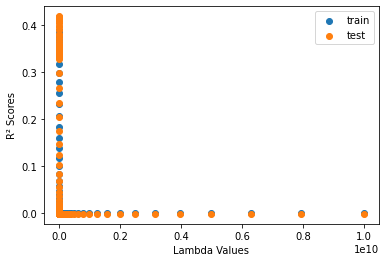

In [55]:
ridge(new_df)

R² training set : 0.35083674395030706
R² test set : 0.4118675761344328


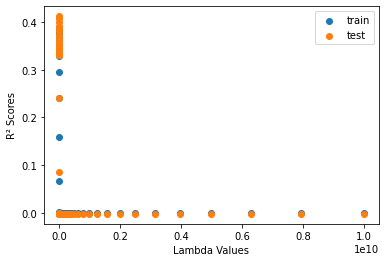

In [56]:
lasso(new_df)

In [57]:
x, y, x_train, x_test, y_train, y_test, y_pred, results = report_scores(new_df)
results

R² training set : 0.3875100534825997
R² test set : 0.33112342556243335

Mean Squared Error : 19.72580714490997
Mean Absolute Error : 3.121468249883024



,Features,Coefficients,Squared
0,Intercept,-1441.718275,2.078552e+06
1,Rating,-7.137350,5.094177e+01
2,Customers_Rated,-0.000110,1.207714e-08
3,Year,0.734870,5.400338e-01
4,Fiction,-0.482722,2.330206e-01
5,Non Fiction,0.482722,2.330206e-01


In [74]:
X, X_test, y, y_test = train_test_split(df[['Customers_Rated']], 
                                        df['Price'], test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=40)
lm=LinearRegression()
lm1= lm.fit(X_train,y_train)
y_pred_val=lm1.predict(X_val)
y_pred_train=lm1.predict(X_train)
y_pred_test=lm1.predict(X_test)
print("Score of training set = ",lm1.score(X_train,y_train))

Score of training set =  0.05883927604282979


In [75]:


def diagnostic_plot(x, y):
    plt.figure(figsize=(20,5))
    
    rgr = LinearRegression()
    rgr.fit(x,y)
    pred = rgr.predict(x) # "regression prediction"

    plt.subplot(1, 3, 1)
    plt.scatter(x,y) # "scatter"
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel("y")
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res) # "scatter supposed to have no pattern"
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt) # "normal qq plot"
    plt.title("Normal Q-Q plot")



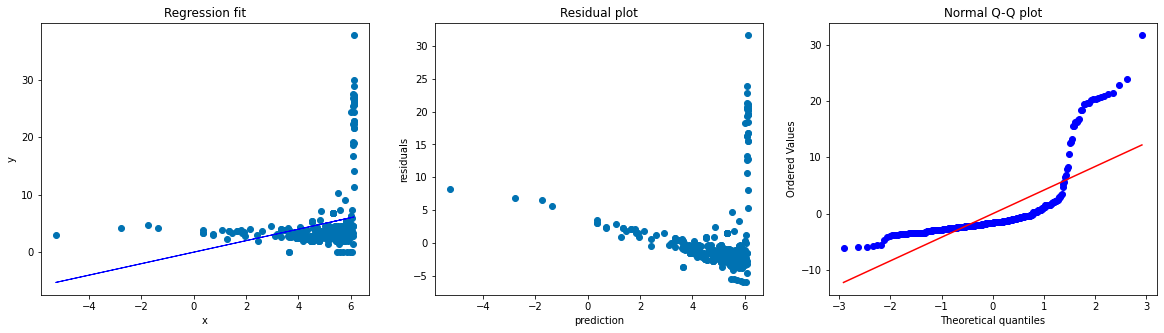

In [76]:
diagnostic_plot(y_pred_train.reshape(390,1), y_train)


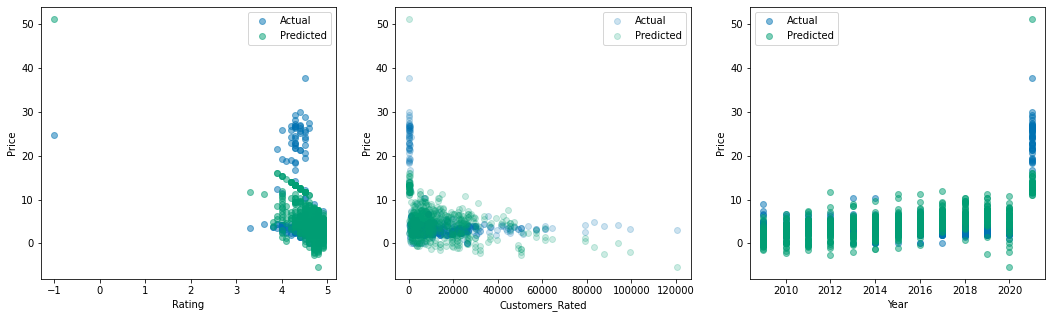

In [58]:
#'Rating',	'Customers_Rated'	,	'Year'

plt.figure(figsize=(18,5))
plt.style.use("seaborn-colorblind")

plt.subplot(1,3,1)
plt.scatter(x["Rating"], y, label="Actual" ,  alpha=0.5)
plt.scatter(x["Rating"], y_pred, label="Predicted" ,  alpha=0.5)
plt.xlabel("Rating")
plt.ylabel("Price")
plt.legend()

plt.subplot(1,3,2)
plt.scatter(x["Customers_Rated"], y, label="Actual" ,  alpha=0.2)
plt.scatter(x["Customers_Rated"], y_pred, label="Predicted" ,  alpha=0.2)
plt.xlabel("Customers_Rated")
plt.ylabel("Price")
plt.legend()
plt.subplot(1,3,3)
plt.scatter(x["Year"], y, label="Actual" ,  alpha=0.5)
plt.scatter(x["Year"], y_pred, label="Predicted" ,  alpha=0.5)
plt.xlabel("Year")
plt.ylabel("Price")
plt.legend();


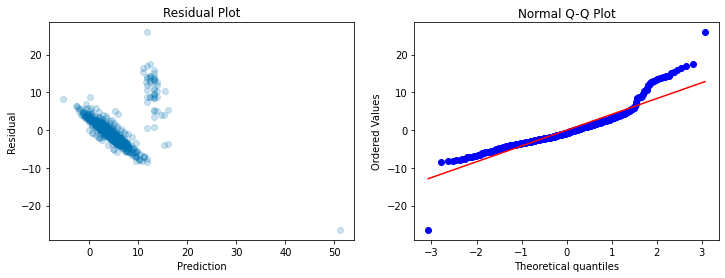

In [59]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.scatter(y_pred, y - y_pred , alpha=0.2)
plt.xlabel("Prediction")
plt.ylabel("Residual")
plt.title("Residual Plot")

plt.subplot(1,2,2)
stats.probplot(y - y_pred, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot"); 
